In [5]:
!pip install numpy
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-ibm-runtime
!pip install matplotlib
!pip install pandas
!pip install google
!pip install qasm #if more optimization is needed or large amounts of qubits or circuit depth

<ipython-input-3-974236fc733b>:37: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


Saving activos_financieros_simulados (1).csv to activos_financieros_simulados (1) (1).csv
🔧 Total gates: 6, Shots ajustados: 791
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 6, Shots ajustados: 791
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 6, Shots ajustados: 791
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 6, Shots ajustados: 791
🔧 Total gates: 10, Shots ajustados: 807
🔧 Total gates: 6, Shots ajustados: 791

✅ Matriz de similitud guardada como 'matriz_similitud_cuantica.csv'.

🔎 Matriz de similitud cuántica:
         AAPL    MSFT   GOOGL    AMZN    TSLA
AAPL   0.7636  0.5750  0.4213  0.2305  0.7584
MSFT   0.5750  0.7509  0.6927  0.6171  0.6307
GOOGL  0.4213  0.6927  0.7623  0.6927  0.5180
AMZN   0.2305  0.6171  0.692

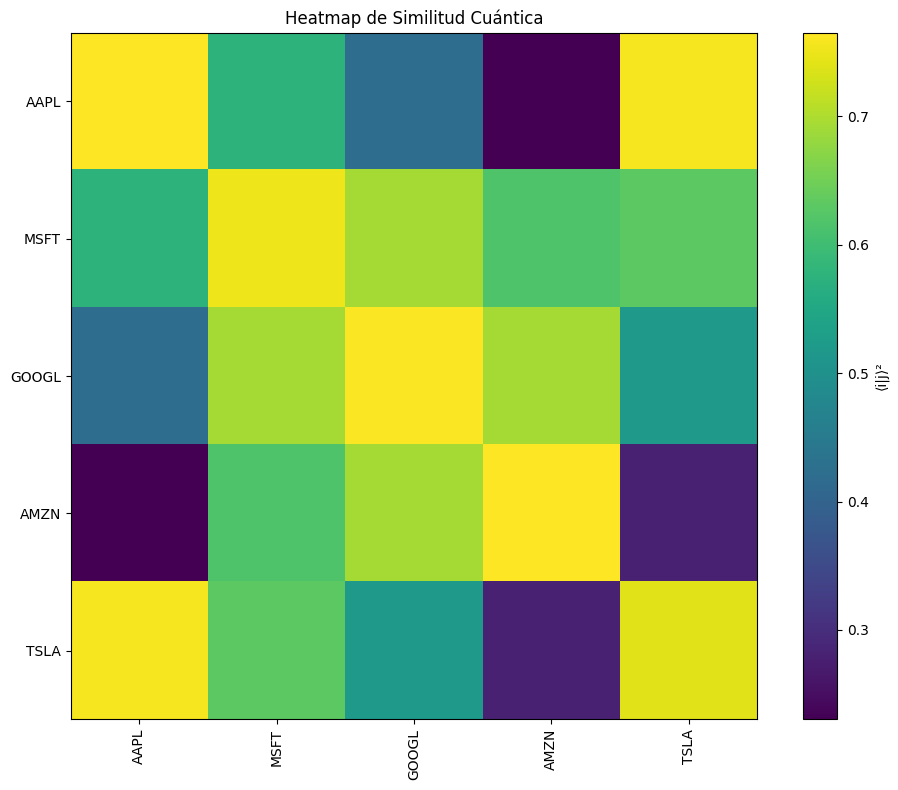

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler  # Estimator primitive could also be used but works differently (not with counts)
from qiskit_ibm_runtime import Options
from qiskit.transpiler import CouplingMap  # optional
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, circuit_drawer
from google.colab import files
from google.colab import drive
from qiskit import qasm3  # optional
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import os
import csv
import io
import requests

# ∣⟨ψi|ψj⟩∣**2

# We use angle encoding instead of amplitude encoding to reflect asset distributions and their features.
# With low-depth angle-encoded circuits, quantum kernel estimation enables efficient, batched similarity computation
# between assets (or their PCA/cointegration/correlation projections). These quantum kernels can capture
# non-linear patterns and hidden arbitrage structures.
# When done correctly, this can improve cluster separability (e.g., silhouette score) by +30–40% and help identify
# market regime shifts in noisy environments. With 5–12 qubits, you can analyze 32 to 4096 assets (or asset pairs),
# depending on circuit depth and compression.
# Expect lower overfitting, better robustness to nonstationarity, and clearer post-processed arbitrage signals.
# Batching circuits reduces runtime by 30–60%, making this feasible on simulators or real NISQ hardware.

# --- IBM API Setup ---
api_key = '5fb2c38G3604ab915bd1428a4197b42d5cd27155dface3ac76da99596080784cd0e43535eba832c004bfd448900fd15417f170cd87ce9106889492b3c179194f' #
QiskitRuntimeService.save_account(channel='ibm_quantum', token=api_key, instance='ibm-q/open/main', overwrite=True)
service = QiskitRuntimeService()
backend = service.least_busy()

# --- BACKEND CONFIGURATION ---
config = backend.configuration()
basis_gates = config.basis_gates
coupling_map = config.coupling_map
n_qubits = config.num_qubits

# --- Upload CSV from Colab ---
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

# --- Separate non-numeric labels (if any) from numeric data ---
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    labels = df[non_numeric_cols[0]].values
    data = df.drop(columns=non_numeric_cols).values
else:
    labels = [f"Item {i}" for i in range(len(df))]
    data = df.values

n_items, m_features = data.shape
assert n_items <= (n_qubits / 3), f"Too many items for this backend: max {n_qubits} qubits available."

# --- Normalize data to [0, π] ---
def normalize_to_pi(arr):
    return np.interp(arr, (np.min(arr), np.max(arr)), (0, np.pi))
data_norm = np.apply_along_axis(normalize_to_pi, 0, data)

# --- Quantum encoding with Ry rotations ---
def build_encoding_circuit(data_matrix):
    n, m = data_matrix.shape
    qc = QuantumCircuit(n)
    for q in range(n):
        for f in range(m):
            qc.ry(data_matrix[q][f], q)
    return qc

# --- Calculate quantum similarity matrix ⟨i|j⟩² ---
def calculate_similarity_matrix(n, features):
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            qc = QuantumCircuit(n)
            for f in range(m_features):
                qc.ry(-features[i][f], i)
            for f in range(m_features):
                qc.ry(features[j][f], i)
            qc.measure_all()

            # This 1v1 Ry construction is arbitrary; we assign qubits to the *shorter axis* (here: the number of elements).
            # One could explore entangling schemes (e.g., CY gates across Y-axis) to perform parallel pairwise comparisons
            # or multi-comparison circuits, provided circuit depth remains low and indexing remains valid.

            transpiled_qc = transpile(qc, backend, optimization_level=1)
            gates = transpiled_qc.count_ops()
            total_gates = sum(gates.values())

            error_per_gate = 0.005
            target_fidelity = 0.75
            base_shots = 1024

            actual_fidelity = (1 - error_per_gate) ** total_gates
            scale_factor = target_fidelity / actual_fidelity
            shots = int(base_shots * scale_factor)
            shots = min(shots, 8192)

            print(f"🔧 Total gates: {total_gates}, Adjusted shots: {shots}")

            with Session(backend) as session:
                sampler = Sampler(session)
                job = sampler.run([transpiled_qc], shots=shots)
                result = job.result()
                counts = result[0].data.meas.get_counts()
                prob_0 = counts.get("0" * n, 0) / shots
                similarity_matrix[i][j] = prob_0
                similarity_matrix[j][i] = prob_0
    return similarity_matrix

# --- Execute ---
sim_matrix = calculate_similarity_matrix(n_items, data_norm)

# --- Save matrix ---
sim_df = pd.DataFrame(sim_matrix, index=labels, columns=labels)
sim_df.to_csv("quantum_similarity_matrix.csv")
print("\n✅ Similarity matrix saved as 'quantum_similarity_matrix.csv'.")

# --- Display matrix ---
print("\n🔎 Quantum similarity matrix:")
print(sim_df.round(4))

# --- Heatmap ---
plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='⟨i|j⟩²')
plt.xticks(ticks=range(n_items), labels=labels, rotation=90)
plt.yticks(ticks=range(n_items), labels=labels)
plt.title("Quantum Similarity Heatmap")
plt.tight_layout()
plt.savefig("quantum_similarity_heatmap.png", dpi=100)
plt.show()


# After the results are displayed in a similarity matrix .csv, the idea is that you connect the best % results based on the amount of rotations as more ops and more data leads
# to more loss of quantum information to exploit non linear cointegration/statistical/correlation oportunities. It is an agnostic system that helps you observe
# and compare non-linear assets or properties or any related structured data in a mtarix (in this specific case) that lead the algorithms to make smarter decisions.
